# 木

## 木構造：問題にチャレンジする前に


キーワード：根付き木，節点（node），辺（edge），親（parent），子（child），兄弟（sibling），根（root），内部接点（internal node），葉（leaf），次数（degree），深さ（depth），高さ（height）

### ♠木を扱うライブラリ


根付き木の表現の問題をnetworkxで解く例を後で示すが，AIZU Online Judgeでは使えないし，そもそも，ここで扱う問題では，あまり御利益がない。

|                  | anytree        | networkx                     |
|------------------|----------------|------------------------------|
| 用途             | 木構造         | グラフ（後の章でも使える。） |
| Google Colab     | 要インストール | ○                            |
| ノードの種類判別 | ○              | △                            |
| 深さ             | ○              | △                            |
| 高さ             | ○              | ×                            |
| 子の取得         | ○              | ○                            |
| 木の巡回         | inorder以外は○ | ×                            |
| 可視化           | ○              | ○                            |

### プログラミングテクニック


printで改行しない。

In [ ]:
print("foo", end="")
print("bar")

入力の，後ろの方をまとめてリストに格納する方法

In [ ]:
a, *b = [1, 2, 3, 4]
print(a)
print(b)

文字列表示で便利な機能

In [ ]:
foo = 123
print(f'foo = {foo}')
print(f'{foo = }')

Noneと空のリストの検査

| チェック内容           | 安全な書き方        | 危険な書き方 |
|------------------------|---------------------|--------------|
| `a` が `None` か       | `if a is None:`     | `if not a:`  |
| `a` が `None` でないか | `if a is not None:` | `if a:`      |
| リスト`a`が空か        | `if len(a) == 0:`   | `if not a:`  |
| リスト`a`が空でないか  | `if len(a) > 0:`    | `if a:`      |

## 根付き木の表現


問題：[ALDS 1_7_A](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_A) (Rooted Trees)

In [1]:
%%writefile input1.dat
13
0 3 1 4 10
1 2 2 3
2 0
3 0
4 3 5 6 7
5 0
6 0
7 2 8 9
8 0
9 0
10 2 11 12
11 0
12 0

Writing input1.dat


### ♠networkxを使った解法

node 0: parent = -1, depth = 0, root, [1, 4, 10]
node 1: parent = 0, depth = 1, internal, [2, 3]
node 2: parent = 1, depth = 2, leaf, []
node 3: parent = 1, depth = 2, leaf, []
node 4: parent = 0, depth = 1, internal, [5, 6, 7]
node 5: parent = 4, depth = 2, leaf, []
node 6: parent = 4, depth = 2, leaf, []
node 7: parent = 4, depth = 2, internal, [8, 9]
node 8: parent = 7, depth = 3, leaf, []
node 9: parent = 7, depth = 3, leaf, []
node 10: parent = 0, depth = 1, internal, [11, 12]
node 11: parent = 10, depth = 2, leaf, []
node 12: parent = 10, depth = 2, leaf, []


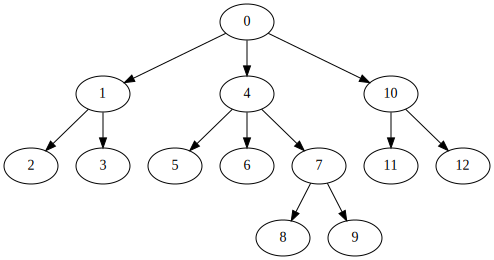

In [2]:
import networkx as nx

with open('input1.dat') as f: lines = f.readlines()

G = nx.DiGraph()

n = int(lines[0])
for line in lines[1:]:
  parent, _, *children = list(map(int, line.split()))
  for child in children: G.add_edge(parent, child)
  # ここで親子関係や子のリストを記憶すれば話は簡単だが，ここでは汎用的な方法を示す。

def node_type(G, node):
  if G.in_degree(node) == 0: return "root"    # 入次数が0なら根
  elif G.out_degree(node) == 0: return "leaf" # 出次数が0なら葉
  return "internal"                           # 他は内部節点

# 入次数が0のものが根（根付き木では1個しかない）
root = [node for node, degree in G.in_degree() if degree == 0][0]

# 根からの距離が深さ
depths = nx.single_source_shortest_path_length(G, root)

# 全てのノードについて，親を探す
parents = {root: -1} # 根の親はない
for u, v in nx.bfs_edges(G, root): parents[v] = u

for i in range(n):
  parent = parents[i]
  depth = depths[i]
  nodetype = node_type(G, i)
  children = sorted(G.successors(i)) # 入力から明らかだが，ここでは改めて求める。
  print(f'node {i}: {parent = }, {depth = }, {nodetype}, {children}')

# おまけ（可視化）
import graphviz
dot = graphviz.Digraph()
dot.edges((str(u), str(v)) for u, v in G.edges)
dot

anytreeのコードは，このコードをAIで翻訳すれば得られるだろう。

### 自分で実装する


教科書では**左子右兄弟表現**を使っているが，ここでは最低限の実装で済ませる（教科書も，左子右兄弟表現はこの問題でしか使っていない）。

ここで理解したいこと：

-   ノードをクラスで表現する。
-   木の操作（ここでは深さの計算）には再帰が向いている。
-   木を管理する変数をグローバル変数にするか，引数で渡すか（Program 8.2，8.3，8.4を参照）。

In [3]:
%%writefile test.py
class Node:
  def __init__(self, key):
    self.key = key
    self.parent = None
    self.children = []

  def getDepth(self):
    if self.parent is None: return 0  #親がないなら深さ０
    return self.parent.getDepth() + 1 #親の深さ＋１

  def getNodetype(self):
    if self.parent is None: return "root" #親がないならroot
    if len(self.children) > 0: return "internal node" #子がいたらinternal node
    return "leaf" #いずれでもなければleaf

  def __str__(self):# printで呼ばれたとき何を返すのか
    parent = self.parent.key if self.parent is not None else -1
    depth = self.getDepth()
    return f'node {self.key}: {parent = }, {depth = }, {self.getNodetype()}, {self.children}'

# 入力
n = int(input())
T = [Node(k) for k in range(n)] # ノードのリストを木とみなす。

for _ in range(n):
  k, _, *children = map(int, input().split())#データを読みこむ
  node = T[k]             #ノードを取り出す
  node.children = children#子を記憶する
  for c in children: T[c].parent = node#親を記録する

for node in T: print(node)

Writing test.py


In [ ]:
!python3 test.py < input1.dat

うまく行ったら提出する。

## 二分木の表現


問題：[ALDS 1_7_B](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_B) (Binary Tree)

ここで理解したいこと：

-   二分木のノードの実装
-   （再帰）兄弟を求めるときは，自分が左の子なのか右の子なのかを知る必要がある。
-   （再帰）ノードの高さは，左の子の高さと右の子の高さの最大値に1を足すことで求められる。

In [ ]:
%%writefile input2.dat
9
0 1 4
1 2 3
2 -1 -1
3 -1 -1
4 5 8
5 6 7
6 -1 -1
7 -1 -1
8 -1 -1

In [ ]:
%%writefile test.py
class Node:
  def __init__(self, key):
    self.key = key
    self.parent = None
    self.left = None
    self.right = None

  def getDepth(self):
    if self.parent is None: return 0
    return self.parent.getDepth() + 1

  def getNodetype(self):
    if self.parent is None: return "root"
    if self.left is not None or self.right is not None: return "internal node"
    return "leaf"

  def getSibling(self):
    if self.parent is None: return None
    # 自分で書く。

  def getDegree(self):
    degree = 0
    if self.left: degree += 1
    if self.right: degree += 1
    return degree

  def getHeight(self):
    # 自分で書く。
    if self.left is not None: return self.left.getHeight() + 1
    if self.right is not None: return self.right.getHeight() + 1
    return 0

  def __str__(self):
    parent = self.parent.key if self.parent is not None else -1
    sibling = self.getSibling().key if self.getSibling() is not None else -1
    degree = self.getDegree()
    depth = self.getDepth()
    height = self.getHeight()
    return f'node {self.key}: {parent = }, {sibling = }, {degree = }, {depth = }, {height = }, {self.getNodetype()}'

n = int(input())
T = [Node(k) for k in range(n)] # ノードをリストを木とみなす。

for _ in range(n):
  k, left, right = map(int, input().split())
  node = T[k]
  if left != -1: node.left = T[left]
  if right != -1: node.right = T[right]
  if node.left is not None: node.left.parent = node
  if node.right is not None: node.right.parent = node

for node in T: print(node)

In [ ]:
!python3 test.py < input2.dat

うまく行ったら提出する。

## 木の巡回


問題：[ALDS 1_7_C](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_C) (Tree Walk)

ここで理解したいこと：

-   木の巡回方法3種類

In [ ]:
%%writefile test.py
class Node:
  def __init__(self, key):
    self.key = key
    self.parent = None
    self.left = None
    self.right = None

n = int(input())
T = [Node(k) for k in range(n)] # ノードをリストを木とみなす。

for _ in range(n):
  k, left, right = map(int, input().split())
  node = T[k]
  if left != -1: node.left = T[left]
  if right != -1: node.right = T[right]
  if node.left is not None: node.left.parent = node
  if node.right is not None: node.right.parent = node

# ここまでは前と同じ

def preParse(u):
  if u is None: return
  print(f' {u.key}', end='')
  preParse(u.left)
  preParse(u.right)

def inParse(u):
  # 自分で書く。

def postParse(u):
  if u is None: return
  postParse(u.left)
  postParse(u.right)
  print(f' {u.key}', end='')

# 親のないノードが根である。
root = [node for node in T if node.parent is None][0]

print("Preorder")
preParse(root)
print()

print("Inorder")
inParse(root)
print()

print("Postorder")
postParse(root)
print()

In [ ]:
!python3 test.py < input2.dat

うまく行ったら提出する。

## ♠木の巡回の応用：木の復元


問題：[ALDS 1_7_D](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_D) (Reconstruction of a Tree)

## 宿題


以下の問題をAC（Accepted）にする。Pythonを使うこと。

-   [ALDS 1_7_A](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_A) (Rooted Trees)
-   [ALDS 1_7_B](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_B) (Binary Tree)
-   [ALDS 1_7_C](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_C) (Tree Walk)
-   ♠[ALDS 1_7_D](https://onlinejudge.u-aizu.ac.jp/courses/lesson/1/ALDS1/7/ALDS1_7_D) (Reconstruction of a Tree)

以上